# Identifying Vehicles

This is dataset I created after the lesson1 with 10 different types of vehicles. Let's see how we can train a model for that.

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
from fastai import *
from fastai.vision import *

In [39]:
dataset_url = "https://github.com/arunoda/fastai-courses/releases/download/fastai-vehicles-dataset/fastai-vehicles.tgz"

## Loading Data

Currently it's not possible to load data using `untar_data` for data stored in GitHub.<br/>
So, I've to come up with the following utility function to support that.

In [40]:
import os
import subprocess

def exec(commands, cwd=None, show_output=False):
  FNULL = open(os.devnull, 'w')
  if show_output == True:
    cp = subprocess.run(commands, cwd=cwd, universal_newlines=True)
  else:
    cp = subprocess.run(commands, cwd=cwd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
  
  if cp.returncode != 0:
    raise Exception(cp.stdout)

def get_data(name, url):
  homedir = os.getenv('HOME')
  datadir = f'{homedir}/userdata'
  tmpdir = f'/tmp/{name}'
  tarfile = f'{tmpdir}/data.tgz'
  finaldir = f'{datadir}/{name}'

  if os.path.exists(finaldir):
    return Path(finaldir)

  exec(['rm', '-rf', tmpdir])
  exec(['mkdir', '-p', tmpdir])
  exec(['curl', '-L', url, '--output', tarfile], show_output=True)
  exec(['tar', 'xzf', tarfile], cwd=tmpdir)
  exec(['rm', tarfile])

  exec(['rm', '-rf', datadir])
  exec(['mkdir', '-p', datadir])
  exec(['mv', tmpdir, datadir])
  
  return Path(finaldir)

In [41]:
path = get_data("fastai-vehicles", dataset_url); path

PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles')

In [42]:
path.ls()

['images']

In [43]:
path_img = path/'images'
fnames = get_image_files(path_img)
len(fnames)

1204

In [44]:
fnames[:5]

[PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/ suzuki-wagonr-60.jpg'),
 PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/ suzuki-wagonr-97.jpg'),
 PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/audi-q2-67.jpg'),
 PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/audi-a3-64.jpg'),
 PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/ suzuki-wagonr-40.jpg')]

Okay. Now we've some idea of our dataset. Let's try to create a DataBunch from these images.

In [45]:
pattern = r' *([^/]+)-\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pattern, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

In [46]:
print(len(data.classes))
data.classes

10


['suzuki-wagonr',
 'audi-q2',
 'audi-a3',
 'honda-crv',
 'rangerover',
 'suzuki-swift',
 'defender',
 'honda-civic',
 'jeep-wrangler',
 'honda-fit']

Let's see some random images from our dataset.

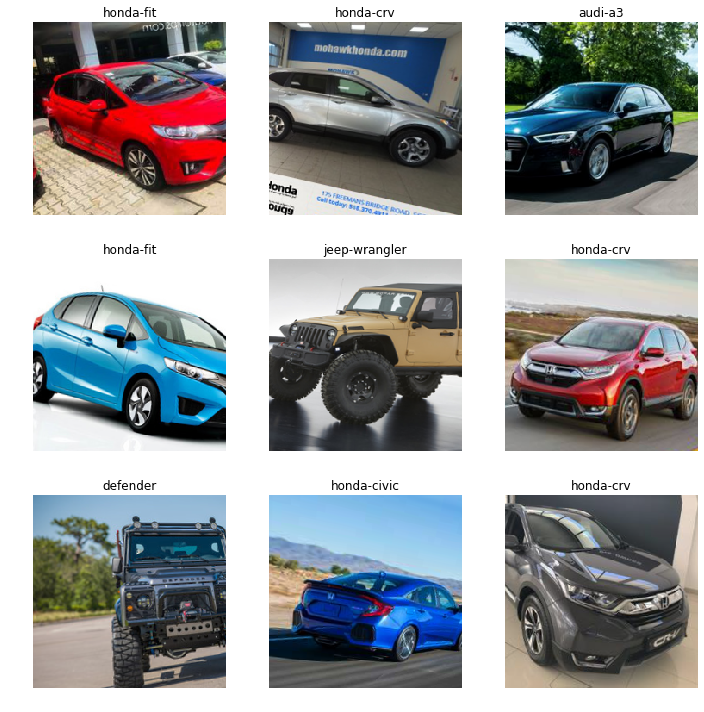

In [47]:
data.show_batch(3, (10, 10))

## Training: resnet34

Let's try to train a model with these data.

In [48]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

Total time: 00:21
epoch  train_loss  valid_loss  error_rate
1      2.161902    1.241149    0.437229    (00:05)
2      1.509486    0.708808    0.225108    (00:05)
3      1.128818    0.627503    0.155844    (00:05)
4      0.921622    0.602121    0.160173    (00:05)



In [49]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


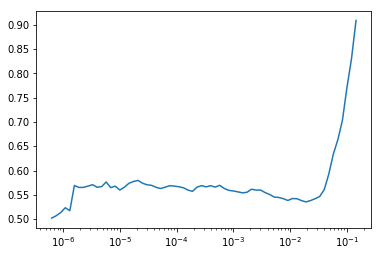

In [50]:
learn.recorder.plot()

In [51]:
learn.unfreeze()

In [52]:
learn.fit_one_cycle(2, slice(1e-6, 1e-3))

Total time: 00:11
epoch  train_loss  valid_loss  error_rate
1      0.534910    0.513454    0.112554    (00:06)
2      0.455375    0.474585    0.116883    (00:05)



## Inspect Result

Here we have an error rate of 15%. Which is bit higher. (But not bad). <br/>
Let's see what has happened to our model.

In [53]:
interpret = ClassificationInterpretation.from_learner(learn)

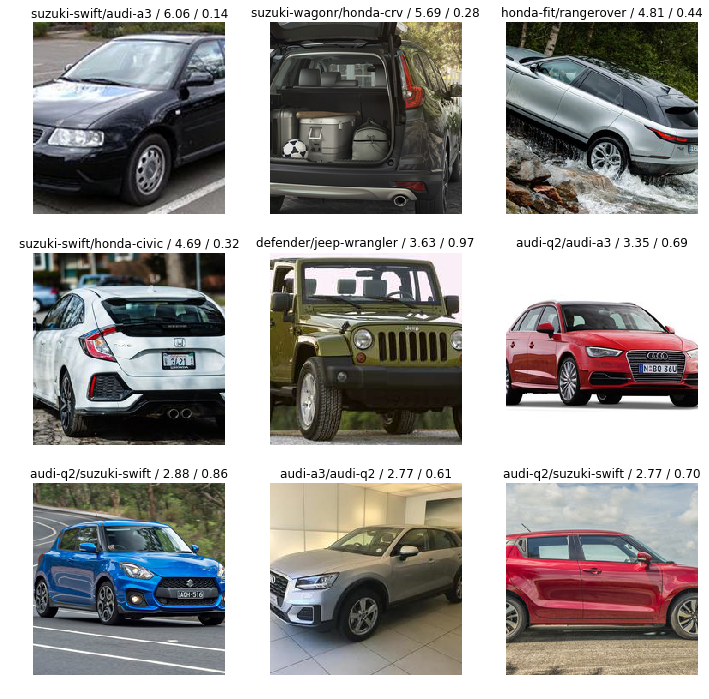

In [54]:
interpret.plot_top_losses(9)

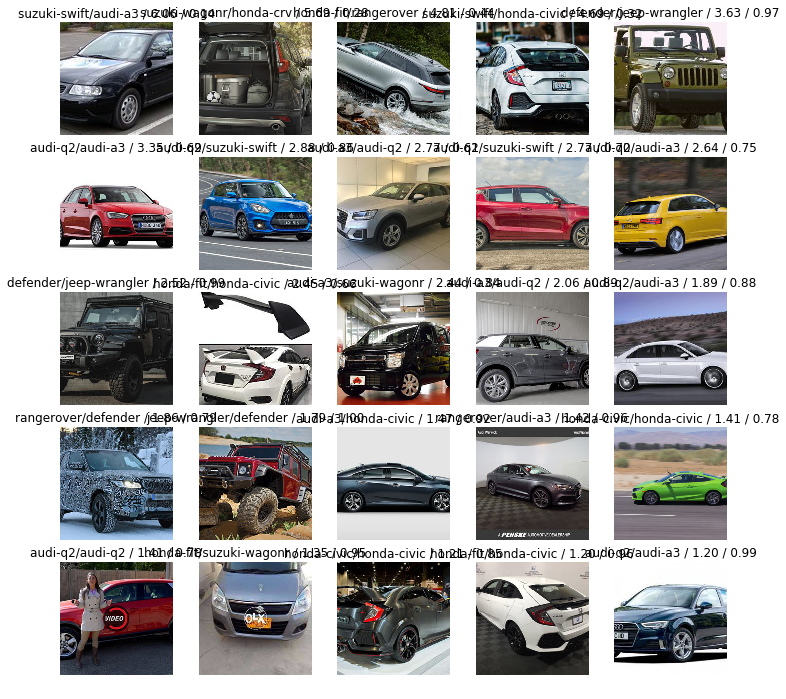

In [55]:
interpret.plot_top_losses(25)

Based on above images, it seems like we can may be improve our images.<br/>
Some of them are quiet fine.<br/>
Let's have a look at the confusion metrics.

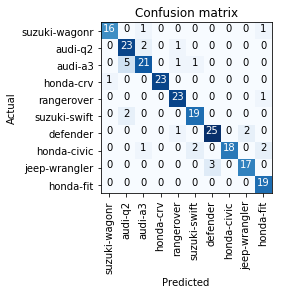

In [56]:
interpret.plot_confusion_matrix()

In [57]:
interpret.most_confused(1)

[('audi-a3', 'audi-q2', 5),
 ('jeep-wrangler', 'defender', 3),
 ('audi-q2', 'audi-a3', 2),
 ('suzuki-swift', 'audi-q2', 2),
 ('defender', 'jeep-wrangler', 2),
 ('honda-civic', 'suzuki-swift', 2),
 ('honda-civic', 'honda-fit', 2)]

## Optimization Idea 1: Use resnet50

In [58]:
opt1 = ConvLearner(data, models.resnet50, metrics=error_rate)
opt1.fit_one_cycle(4)

Total time: 00:28
epoch  train_loss  valid_loss  error_rate
1      1.730650    0.856795    0.329004    (00:08)
2      1.110315    0.587803    0.203463    (00:06)
3      0.821993    0.512670    0.190476    (00:06)
4      0.660808    0.492969    0.173160    (00:06)



In [59]:
opt1.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


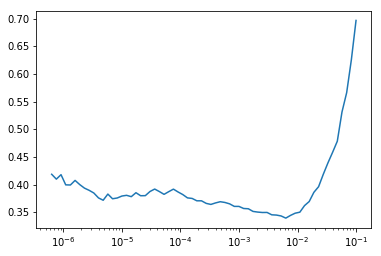

In [60]:
opt1.recorder.plot()

In [61]:
opt1.unfreeze()
opt1.fit_one_cycle(2, slice(1e-6, 1e-3))

Total time: 00:16
epoch  train_loss  valid_loss  error_rate
1      0.379199    0.452272    0.151515    (00:08)
2      0.297239    0.431862    0.134199    (00:08)



**Notes**

The improvement we got here is not that good or worst. <br/>
(It's getting changed slighly as we run out dataset)<br/>
So, I think we can do a lot with our dataset.